In [1]:
import os
import hydromt
import numpy as np
import xarray as xr
from hydromt_sfincs import SfincsModel, utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
'''
Author: LEG
Date: 8/28/2024
Description: This script can be used for processing the SFINCS tmax (time of inundation) output into a usable format for exporting and plotting
'''

'\nAuthor: LEG\nDate: 8/28/2024\nDescription: This script can be used for processing the SFINCS tmax (time of inundation) output into a usable format for exporting and plotting\n'

In [3]:
os.chdir(r'Z:\users\lelise\projects\HCFCD\sfincs_models\03_for_TAMU\DesignStorms\0.5inch_increments')
model_root = 'hcfcd_100m_sbg5m_v2_ksat75'
mod = SfincsModel(model_root, mode='r')
print(mod.results.keys())
print(mod.results['tmax'])

dict_keys(['inp', 'msk', 'qinf', 'zb', 'zs', 'Seff', 'zsmax', 'tmax', 'total_runtime', 'average_dt'])
<xarray.DataArray 'tmax' (timemax: 1, y: 1447, x: 1096)>
dask.array<open_dataset-tmax, shape=(1, 1447, 1096), dtype=timedelta64[ns], chunksize=(1, 1447, 1096), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 3.261e+06 3.262e+06 ... 3.406e+06 3.406e+06
  * x            (x) float64 2.12e+05 2.121e+05 ... 3.214e+05 3.215e+05
  * timemax      (timemax) datetime64[ns] 2022-01-02T00:00:02.921875
    spatial_ref  int32 0
Attributes:
    standard_name:  duration cell is considered wet
    long_name:      duration_wet_cell
    cell_methods:   time: sum


In [8]:
# Get the time of inundation above twet_threshold
tmax = mod.results['tmax'].max(dim='timemax')

# Create a mask of the NaT values
mask = np.isnat(tmax.values)

# Convert timedelta64[ns] to float
tmax = tmax.astype(float)  

# Mask out the NaT values
tmax = tmax.where(~mask, np.nan)

# Convert nanoseconds to hours
tmax = tmax / (3.6 * 10 ** 12)

# Subset the data futher with a minimum time threshold of interest
twet_min = 0  # hours
tmax = xr.where(tmax >= twet_min, tmax, np.nan)

In [9]:
# Output the tmax as a raster
tmax.raster.set_crs(mod.crs)
tmax.raster.set_nodata(np.nan)
tmax.raster.to_raster(os.path.join(mod.root, f'tmax_hours.tif'))

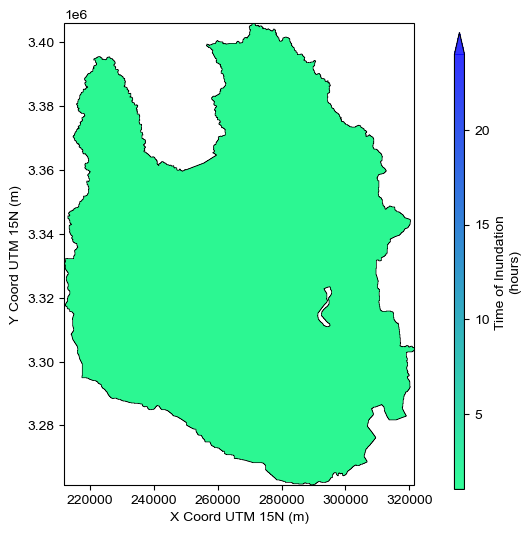

In [10]:
font = {'family': 'Arial', 'size': 10}
mpl.rc('font', **font)
cmap = mpl.cm.binary
wkt = mod.grid['dep'].raster.crs.to_wkt()
utm_zone = mod.grid['dep'].raster.crs.to_wkt().split("UTM zone ")[1][:3]
utm = ccrs.UTM(int(utm_zone[:2]), "S" in utm_zone)
extent = np.array(mod.region.total_bounds)[[0, 2, 1, 3]]

# Now Plot!
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 6), subplot_kw={'projection': utm}, 
                        tight_layout=True, layout='constrained')

# Setup the colorbar and plot the raster
ckwargs = dict(cmap='winter_r', vmin=1, vmax=24)
cs1 = tmax.plot(ax=ax, add_colorbar=False, zorder=2, alpha=0.8, **ckwargs)

# Plot background/geography layers
mod.region.plot(ax=ax, color='lightgrey', edgecolor='none', zorder=1, alpha=0.8)
mod.region.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5, linestyle='-', zorder=3, alpha=1)

# Setup plot extent
minx, miny, maxx, maxy = extent
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_extent(extent, crs=utm)
ax.set_title('')

# Setup axis labels
ax.set_ylabel(f"Y Coord UTM {utm_zone} (m)")
ax.yaxis.set_visible(True)
ax.set_xlabel(f"X Coord UTM {utm_zone} (m)")
ax.xaxis.set_visible(True)
ax.ticklabel_format(style='sci', useOffset=False)
ax.set_aspect('equal')

# Colorbar
pos1 = ax.get_position()  # get the original position
cbar_ax = fig.add_axes([pos1.x1 + 0.01, pos1.y0 + pos1.height * .1, 0.02, pos1.height * 0.8])
cb = fig.colorbar(cs1,
                  cax=cbar_ax,
                  shrink=0.7,
                  extend='max',
                  spacing='uniform',
                  label='Time of Inundation\n(hours)',
                  pad=0,
                  aspect=30
                  )

# Save and close plot
plt.gca().ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
plt.subplots_adjust(wspace=0.05, hspace=0.2)
plt.margins(x=0, y=0)
#plt.savefig('design_storm_tmax.png', dpi=225, bbox_inches="tight")
#plt.close()